In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
from zipfile import ZipFile
import PIL

import tensorflow as tf

# tutorial :: 
# https://www.youtube.com/watch?v=7cJfc3Dblng&list=TLPQMTkwODIwMjHLnpSNhuP3Zw&index=4

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"jasmansahi","key":"f4da8edb24dea85f481b8db7d929ada2"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ./kaggle/
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle config path -p /content

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')


In [ ]:
! chmod 600 ./kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!dir

drive  kaggle  kaggle.json  sample_data


In [ ]:
#https://www.kaggle.com/moltean/fruits
! kaggle datasets download moltean/fruits


 99% 1.07G/1.08G [00:10<00:00, 96.1MB/s]
100% 1.08G/1.08G [00:10<00:00, 106MB/s] 


In [ ]:
data_dir = tf.keras.utils.get_file("/content/fruits.zip", "https://www.kaggle.com/moltean/fruits")
#data_dir = "/content/fruits.zip"

In [ ]:
zf = ZipFile("/content/fruits.zip")
zf.extractall("/content")

In [ ]:
train_dir = pathlib.Path("/content/fruits-360_dataset/fruits-360/Training") 
test_dir = pathlib.Path("/content/fruits-360_dataset/fruits-360/Test")

In [ ]:
img_count = list(train_dir.glob("*/*.jpg"))
len(img_count)

67692

visualize

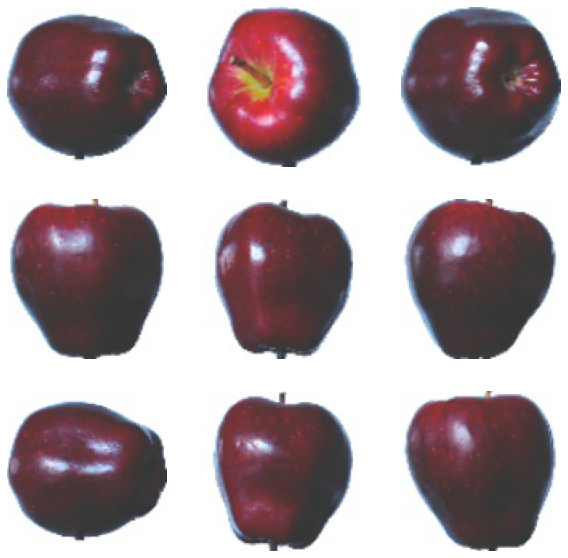

In [ ]:
fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))

plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [ ]:
batch_size = 32
img_h = 100
img_w = 100

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_h, img_w),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_h, img_w),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [ ]:
class_names = train_ds.class_names
num_class = len(class_names)

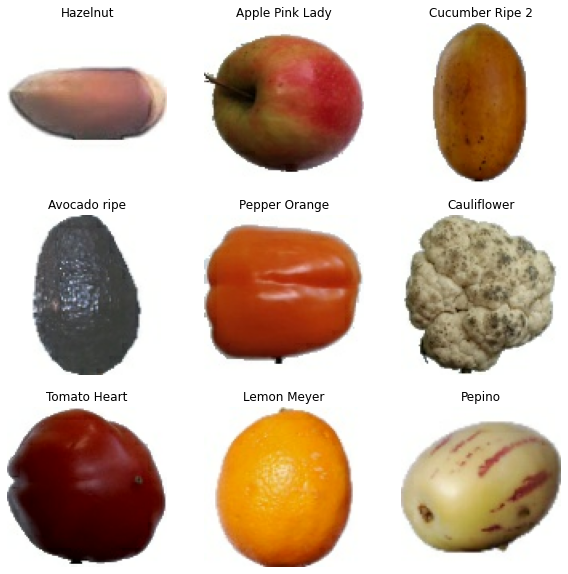

In [ ]:
for images,labels in train_ds.take(1): # take 1 batch
  plt.figure(figsize=(10,10))
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    #img = PIL.Image.open(str(fruits[i]))
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

  plt.show()


preprocessing / basemodel :: transfer learning (resnet)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) # cache and prefetch, so can get data while running current 
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
preprocessing_input =  tf.keras.applications.resnet.preprocess_input

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_h, img_w, 3), # 3 color channels 
    include_top=False,
    weights='imagenet'
)

In [ ]:
base_model.trainable = False # transfer learning, only training last layer, for specific data 

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
prediction_layer = tf.keras.layers.Dense(num_class) #output layer trained

building the model


In [ ]:
inputs = tf.keras.Input(shape=(100,100,3))

x = data_augmentation(inputs) 
x = preprocessing_input(x)
x = base_model(x,training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

training


In [ ]:
model.evaluate(val_ds)

424/424 [==============================] - 532s 1s/step - loss: 6.2207 - accuracy: 0.0055


[6.220740795135498, 0.005539961624890566]

In [ ]:
epochs = 10

history = model.fit(train_ds, epochs = epochs,  validation_data = val_ds)

Epoch 1/10
1693/1693 [==============================] - 2709s 2s/step - loss: 0.0101 - accuracy: 0.9988 - val_loss: 0.0099 - val_accuracy: 0.9994
Epoch 2/10
1693/1693 [==============================] - 2689s 2s/step - loss: 0.0085 - accuracy: 0.9989 - val_loss: 0.0073 - val_accuracy: 0.9996
Epoch 3/10
1693/1693 [==============================] - 2705s 2s/step - loss: 0.0075 - accuracy: 0.9990 - val_loss: 0.0066 - val_accuracy: 0.9999
Epoch 4/10
1693/1693 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9991

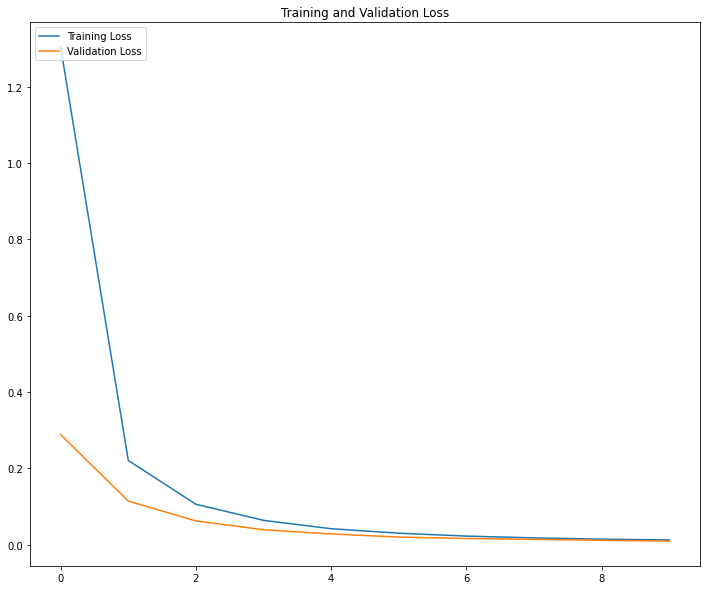

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
np.argmin(val_loss)

9